In [1]:
#############################################################################################
# The code is running with Tensroflow 1.15 
# on docker tensorflow/tensorflow:1.15.0-gpu-py3 (with additional packages: scikit/scikit-image/keras)
# And I add import tensorflow.compatv1 as tf in the original project
#############################################################################################
# I met
# Error : Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
# https://github.com/tensorflow/tensorflow/issues/24828
# Suggests the following solution

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config0 = ConfigProto()
config0.gpu_options.allow_growth = True
session = InteractiveSession(config=config0)

####################################################################

# return a list of the file nmaes in the dirtory
from os import listdir
# extracting bounding boxes from an annotation file
#to get the treee from the xml file
from xml.etree import ElementTree 
from numpy import zeros
from numpy import asarray
# Dataset is a class defined in the project
# We need to define load_dataset / load_mask / image_refernce by ourselves
from mrcnn.utils import Dataset # DIfferent from the tutorial why?
# import Mask_RCNN.mrcnn

In [2]:
# define a dataset class
# based on the Dataset class
class KangarooDataset(Dataset):
    def load_dataset(self,dataset_dir,is_train=True):
        #define one class
        # add_class is built in the original class
        self.add_class("dataset",1,"kangaroo")
        
        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'

        # load all images
        for filename in listdir(images_dir):
            image_id = filename[:-4]
            # skip bad images
            if image_id in ['00090']:
                continue
            # divide the dataset into training set and test set
            if is_train and int(image_id) >= 150:
                continue
            if not is_train and int(image_id) < 150:
                continue
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id+'.xml'
            # add to dataset (following the format defined in the project)
            self.add_image('dataset',image_id=image_id,path= img_path,annotation=ann_path)
            
    # define a function to extract the boxes from xml file
    def extract_boxes(self,filename):
        # load and parse the file
        tree = ElementTree.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract all the bounding boxes
        boxes = list()
        for box in root.findall('.//bndbox'): # for all boxes
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            boxes.append([xmin,ymin,xmax,ymax])

        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height
    
    def load_mask(self,image_id):
        # the image id / path / annotation is saved in image_info when loading the dateset
        info = self.image_info[image_id]
        annot_path = info['annotation']
        
        boxes,w,h = self.extract_boxes(annot_path)
        # create masks
        masks = zeros([h,w,len(boxes)]) # could be multiple boxes
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            col_start, col_end = box[0],box[2]
            row_start, row_end = box[1],box[3]
            masks[row_start:row_end,col_start:col_end,i] = 1
            # record the class of each box
            class_ids.append(self.class_names.index('kangaroo'))
        return masks, asarray(class_ids,dtype='int32')
    
    def image_reference(self,image_id):
        info = self.image_info[image_info]
        return info['path']            

In [3]:
train_set = KangarooDataset() 

train_set.load_dataset('kangaroo',is_train=True)

train_set.prepare() # what does this for? It's necessary but why?

print('Train: %d' % len(train_set.image_ids))

Train: 131


In [4]:
test_set = KangarooDataset() 

test_set.load_dataset('kangaroo',is_train=False)

test_set.prepare() # what does this for? It's necessary but why?

print('Test: %d' % len(test_set.image_ids))

Test: 32


In [5]:
#########################################################################################

In [6]:
# test the load_image and load_mask function
image_id = 0
image = train_set.load_image(image_id)
# print(image)
mask, class_ids = train_set.load_mask(image_id)
# print(mask,class_ids)

In [7]:
from matplotlib import pyplot

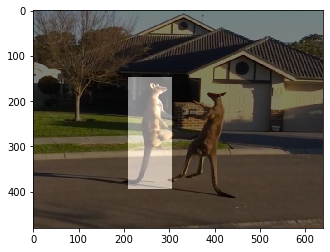

In [8]:
pyplot.imshow(image) # cool, useful

pyplot.imshow(mask[:,:,0],cmap='gray',alpha=0.5)

pyplot.show()
# the first 2 lines could produce 2 images independently, and you can use pyplot.show() to combine them

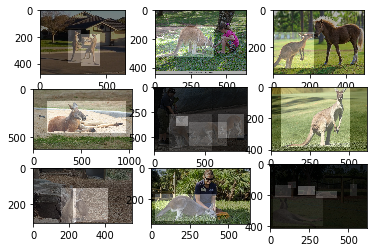

In [9]:
for i in range(9):
    pyplot.subplot(330+1+i) # subplot remember
    image = train_set.load_image(i)
    pyplot.imshow(image)
    mask,class_ids = train_set.load_mask(i)
    for j in range(mask.shape[2]): # use .shape is more elegant
        pyplot.imshow(mask[:,:,j],cmap='gray',alpha=0.3)
pyplot.show()

In [10]:
# image_info
for image_id in train_set.image_ids:
    info = train_set.image_info[image_id]
#     print(info)

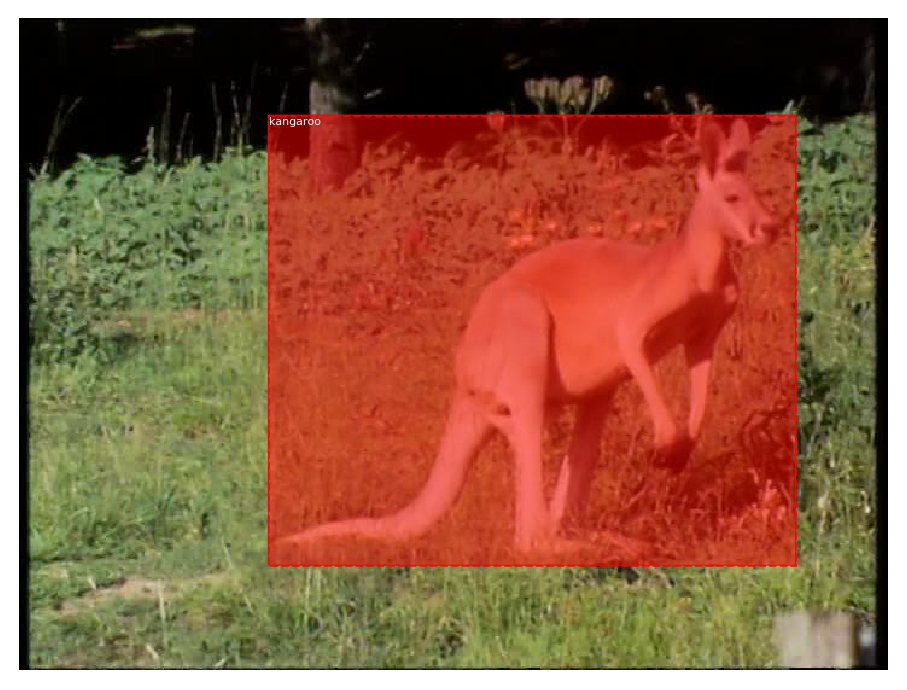

In [11]:
# two build-in functions
from mrcnn.utils import extract_bboxes
from mrcnn.visualize import display_instances

image_id = 20
image = train_set.load_image(image_id)
mask, class_ids = train_set.load_mask(image_id)
bbox = extract_bboxes(mask) # build-in function bbox=bounding box
display_instances(image,bbox,mask,class_ids,train_set.class_names)

In [12]:
#############################################################################################
#Train
#############################################################################################

In [13]:
from mrcnn.config import Config
# define a configuration for the model
class KangarooConfig(Config):
    # GIve the configutation a recognizable name
    NAME = "kangaroo_cfg"
    #Number of classes (background+kangaroo)
    NUM_CLASSES = 1 + 1 
    #Number of training steps per epoch: size of the training set
    STEPS_PER_EPOCH =131
    
config = KangarooConfig()

In [14]:
from mrcnn.model import MaskRCNN
# define the model
model = MaskRCNN(mode='training',model_dir='./',config = config)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



Using TensorFlow backend.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [15]:
# load weights (mscoco, downloaded)
# clss-specific output layers are removed by 'exclude' argument
model.load_weights('mask_rcnn_coco.h5',by_name=True,exclude=["mrcnn_class_logits","mrcnn_bbox_fc","mrcnn_bbox","mrcnn_mask"])

In [16]:
# train the model (output layers or 'heads')
# it seems that the original code cannot run with the latest keras 
# see https://github.com/matterport/Mask_RCNN/issues/1754 
# replace self.keras_model.metrics_tensors.append(loss)
# by self.keras_model.add_metric(loss, name)
#line 2199 in model.py
model.train(train_set,test_set,learning_rate=config.LEARNING_RATE,epochs=5,layers='heads')

# A model file is created and saved at the end of each epoch -> 'kangaroo_cfg'


Starting at epoch 0. LR=0.001

Checkpoint Path: ./kangaroo_cfg20191109T1139/mask_rcnn_kangaroo_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/5
131/131 [==============================] - 71s 544ms/step - loss: 0.5161 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0646 - mrcnn_class_loss: 0.0258 - mrcnn_bbox_loss: 0.1796 - mrcnn_mask_loss: 0.2444 - val_loss: 0.8492 - val_rpn_class_loss: 0.0053 - val_rpn_bbox_loss: 0.2359 - val_mrcnn_class_loss: 0.0065 - val_mrcnn_bbox_loss: 0.3611 - val_mrcnn_mask_loss: 0.2861

Epoch 2/5
131/131 [==============================] - 64s 489ms/step - loss: 0.4106 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0616 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0962 - mrcnn_mask_loss: 0.2324 - val_loss: 0.6948 - val_rpn_class_loss: 0.0021 - val_rpn_bbox_loss: 0.2170 - val_mrcnn_class_loss: 0.0107 - val_mrcnn_bbox_loss: 0.2120 - val_mrcnn_mask_loss: 0.2807
Epoch 3/5
131/131 [==============================] - 66s 501ms/step - loss: 0.4074 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.1004 - mrcnn_class_loss: 0.0252 - mrcnn_bbox_loss: 0.0842 - mrcnn_mask_loss: 0.1940 - val_loss: 1.2294 - val_rpn_cla